In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import io
import pickle
 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Flatten,concatenate,Average
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,LeakyReLU,BatchNormalization,Embedding,Input,Dropout,SpatialDropout1D,GlobalAveragePooling1D,GlobalMaxPooling1D,Concatenate,Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn.metrics import roc_curve,auc,f1_score,confusion_matrix
from tensorflow.keras.initializers import Constant
 
##Source: https://stackoverflow.com/a/14463362/8211103
import warnings
warnings.filterwarnings("ignore")
 
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
def plot_fpr_tpr(y_train,y_pred,ax1,name):
    fpr, tpr, threshold = roc_curve(y_train,y_pred)
    auc_score = round(auc(fpr,tpr),3)
    ax1.plot(fpr,tpr,label=f"{name} Auc-Score: {auc_score}")
    ax1.grid()
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.title.set_text('')
    print(f"{name} Auc-Score: {auc_score}")
    return threshold[np.argmax(tpr*(1-fpr))]
 
def plot(y_train,y_pred,y_test,y_test_pred):
  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
  threshold = plot_fpr_tpr(y_train,y_pred,ax1,'Train')
  _ = plot_fpr_tpr(y_test,y_test_pred,ax1,'Test')
  ax1.legend()
  
  y_pred = (y_pred>threshold).astype(int)
  y_test_pred = (y_test_pred>threshold).astype(int)
 
  cm = confusion_matrix(np.array(y_train),y_pred)
  sns.heatmap(cm,ax=ax2,fmt='6d',annot=True)
  ax2.title.set_text('Train Confution Metrics')
  ax2.set_ylabel('Actual label')
  ax2.set_xlabel('Predicted label')
 
  cm = confusion_matrix(np.array(y_test),y_test_pred)
  sns.heatmap(cm,ax=ax3,fmt='6d',annot=True)
  ax3.title.set_text('Test Confution Metrics')
  ax3.set_ylabel('Actual label')
  ax3.set_xlabel('Predicted label')
 
  ## We will use AUC's threshold for f1 score
  ## Here we will try to get high f1-score for our model
  f11 = round(f1_score(y_train,y_pred),3)
  f12 = round(f1_score(y_test,y_test_pred),3)
  print(f"Train F1-Score: {f11}, Test F1-Score: {f12},")
  return f11,f12
 

 
 
def f1_with_auc(y_train,y_pred):
  y_train = y_train.numpy()
  y_pred = y_pred.numpy()

 
  fpr, tpr, threshold = roc_curve(y_train,y_pred)
  threshold = threshold[np.argmax(tpr*(1-fpr))]
  y_train = (y_train>threshold).astype(int)
  y_pred = (y_pred>threshold).astype(int)
  return f1_score(y_train,y_pred)

In [ ]:
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
small_caps_mapping = { 
    "ᴀ": "a", "ʙ": "b", "ᴄ": "c", "ᴅ": "d", "ᴇ": "e", "ғ": "f", "ɢ": "g", "ʜ": "h", "ɪ": "i", 
    "ᴊ": "j", "ᴋ": "k", "ʟ": "l", "ᴍ": "m", "ɴ": "n", "ᴏ": "o", "ᴘ": "p", "ǫ": "q", "ʀ": "r", 
    "s": "s", "ᴛ": "t", "ᴜ": "u", "ᴠ": "v", "ᴡ": "w", "x": "x", "ʏ": "y", "ᴢ": "z"}
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": 
    "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's":"this is","that'd": "that would", 
    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
    "trump's": "trump is", "obama's": "obama is", "canada's": "canada is", "today's": "today is"}
specail_signs = { "…": "...", "₂": "2"}
specials = ["’", "‘", "´", "`"]

from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()


isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}


def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [ ]:
import pickle
x_train,y_train,x_test,y_test = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/data.pkl','rb'))
embedding_matrix = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/embedding_matrix-fasttext-glove.pkl','rb'))
tok = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/tokenizer-v2.pkl','rb'))
vocab_size = len(tok.word_index)
MAX_LEN = 237
embedding_dim = 300
embedding_layer = Embedding(
    vocab_size + 2,
    embedding_dim*2,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)
loss_weight = 1.0 / y_train[:,-1].mean()

In [ ]:
# less fet
y_train = np.hstack([y_train[:,:9],y_train[:,-1].reshape(-1,1)])
y_test = np.hstack([y_test[:,:9],y_test[:,-1].reshape(-1,1)])

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras import initializers


class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for
    a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 trainable=True,
                                 initializer=self.init)
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0],
                                                   input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 237)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 237, 600)     267883800   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 237, 600)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 237, 512)     1755136     spatial_dropout1d[0][0]          
______________________________________________________________________________________________

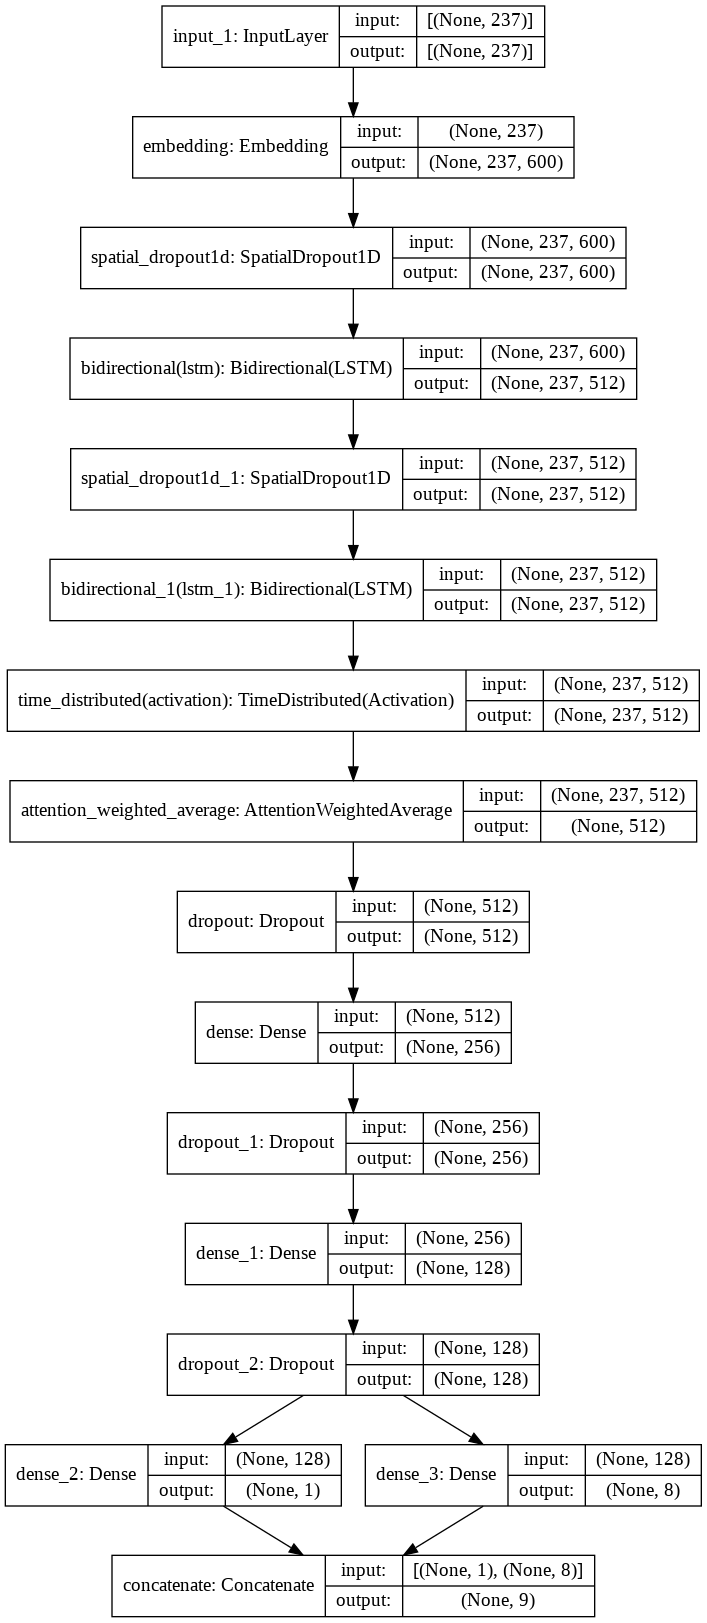

In [ ]:
def create_model():  
    input = Input((MAX_LEN,))
    x = embedding_layer(input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(256,return_sequences=True))(x)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(256,return_sequences=True))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Activation('relu'))(x)
    x = AttentionWeightedAverage()(x)
    x = Dropout(0.5)(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.5)(x)
    output1 = Dense(1)(x)
    output2 = Dense(16)(x)
    output = tf.keras.layers.concatenate([output1,output2])
    return Model(input,output)

model = create_model()
model.summary()
 
plot_model(model,show_shapes=True)

In [ ]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2,verbose = 2, min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
earlystop = EarlyStopping(patience=3,restore_best_weights=True,monitor = 'val_loss')

def in_loss(y_true,y_pred):
    xent = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    loss1 = tf.reduce_mean(xent(y_true[:,0],y_pred[:,0]) * y_true[:,-1])
    loss2 = xent(y_true[:,1:-1],y_pred[:,1:])
    return ((loss1 * loss_weight)*0.60 + loss2*0.40)*2
 
model.compile(optimizer='Adam',loss=in_loss)

In [ ]:
model.fit(x_train,y_train,batch_size=256,epochs=30,validation_data=(x_test,y_test),callbacks=[rlr,earlystop])

Epoch 1/30
6346/6346 [==============================] - 1969s 309ms/step - loss: 0.2059 - val_loss: 0.1617
Epoch 2/30
6346/6346 [==============================] - 1961s 309ms/step - loss: 0.1656 - val_loss: 0.1550
Epoch 3/30
6346/6346 [==============================] - 1962s 309ms/step - loss: 0.1553 - val_loss: 0.1540
Epoch 4/30
6346/6346 [==============================] - 1962s 309ms/step - loss: 0.1477 - val_loss: 0.1508
Epoch 5/30
6346/6346 [==============================] - 1961s 309ms/step - loss: 0.1413 - val_loss: 0.1518
Epoch 6/30
6346/6346 [==============================] - 1962s 309ms/step - loss: 0.1352 - val_loss: 0.1541

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/30
6346/6346 [==============================] - 1961s 309ms/step - loss: 0.1205 - val_loss: 0.1666


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/bi-lstm-attention-v2-less-fet.h5', overwrite=True)

###Reference:
* [keras.io](https://keras.io)
* [tensorflow.org](https://tensorflow.org)
* https://huggingface.co/
* https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification
* https://github.com/jiaruxu233/Jigsaw-Unintended-Bias-in-Toxicity-Classification/blob/master/Harness_the_Beast.ipynb
* https://www.kaggle.com/sandeepkumar121995/keras-bi-gru-lstm-attention-fasttext
* https://github.com/minimaxir/textgenrnn/blob/master/textgenrnn/AttentionWeightedAverage.py
* https://www.researchgate.net/publication/341238064_Avoiding_Unintended_Bias_in_Toxicity_Classification_with_Neural_Networks
* https://www.theseus.fi/bitstream/handle/10024/226938/Quan_Do.pdf
* https://fasttext.cc/
* https://nlp.stanford.edu/projects/glove/
* https://www.nltk.org/

Kaggle Submission:
* Score: 0.92997
* 1787 in TOP in TOP 57.34% 

![](https://drive.google.com/uc?export=view&id=1z1wu55zlyh2PjqLV1d5gq7LnvMZ2uPeU)